In [ ]:
import numpy as np
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim.downloader as api
import pandas as pd

In [2]:
%run ../database.ipynb

In [3]:
df = pd.DataFrame(get_all_content())

In [44]:
preprocessed_text_list = df["preprocessed_text"]
preprocessed_text_token = df["preprocessed_token"]
sentiment_labels = df["siebert_sentiment_label"]
sentiment_scores = df["siebert_sentiment_score"]

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=10000)
X = vectorizer.fit_transform(texts).toarray()

<h2>for sentiment score<h2>

In [9]:
from xgboost import XGBRegressor

X_train, X_test, y_train, y_test = train_test_split(X, sentiment_scores, test_size=0.3, random_state=42)

model = XGBRegressor()
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

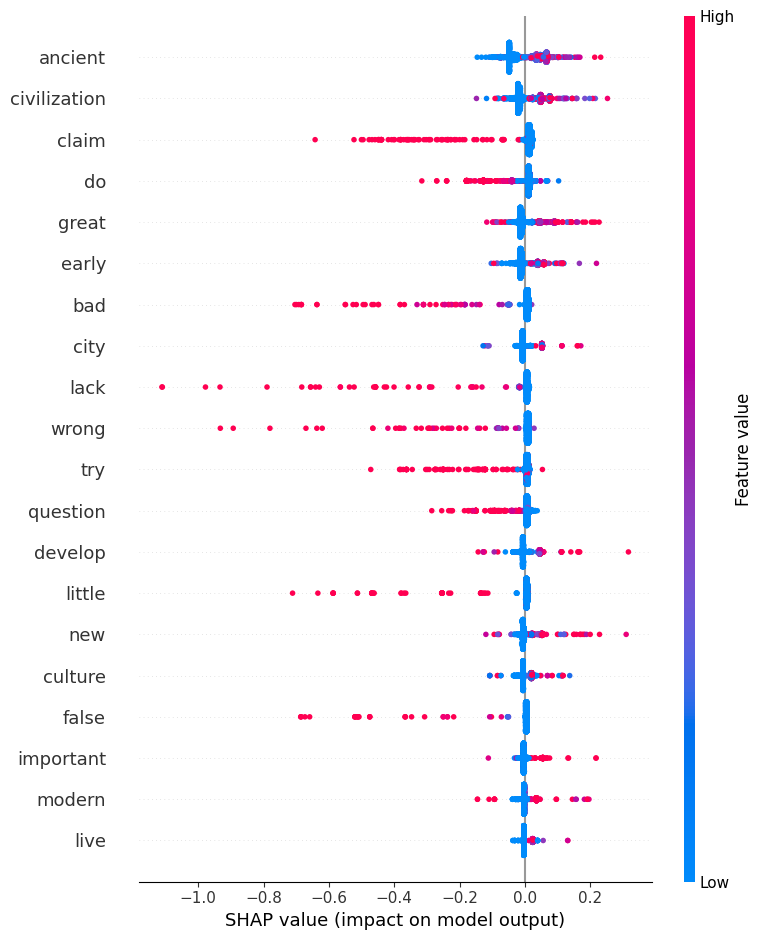

In [ ]:
import shap

explainer = shap.Explainer(model)
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test, feature_names=vectorizer.get_feature_names_out())

In [ ]:
shap.force_plot(explainer.expected_value, shap_values[0], X_test[0], feature_names=vectorizer.get_feature_names_out())

ValueError: visualize() can only display Explanation objects (or arrays of them)!

<h1>line<h1>

In [15]:
pretrained_model = api.load("word2vec-google-news-300")

In [ ]:
vectorizer = TfidfVectorizer(max_features=5000)
tfidf_vectors = vectorizer.fit_transform(texts).toarray()

tfidf_feature_names = vectorizer.get_feature_names_out()

# Word2Vec Feature Extraction (Averaging Word Embeddings)
def get_w2v_vector(doc):
    return np.mean([pretrained_model[word] for word in doc if word in pretrained_model] or [np.zeros(300)], axis=0)

word2vec_vectors = np.array([get_w2v_vector(doc) for doc in texts])

In [19]:
# Combine TF-IDF and Word2Vec
X = np.hstack((tfidf_vectors, word2vec_vectors))

# Feature names for SHAP
feature_names = list(tfidf_feature_names) + [f"W2V_{i}" for i in range(300)]

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, sentiment_scores, test_size=0.3, random_state=42)

In [21]:
# =====================================
# 🔹 STEP 4: XGBoost Hyperparameter Tuning
# =====================================
param_grid = {
    'n_estimators': [100, 500],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5],
    'subsample': [0.7, 1.0]
}

grid_search = GridSearchCV(XGBRegressor(), param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

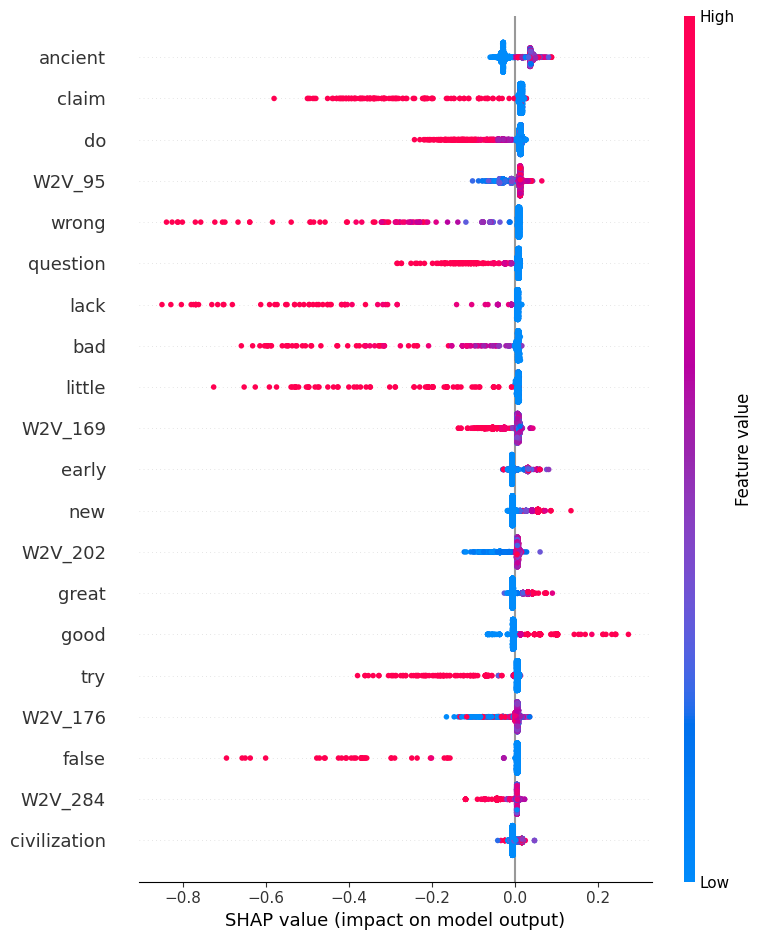

In [22]:
explainer = shap.Explainer(best_model)
shap_values = explainer(X_test)

# Summary Plot (Global Feature Importance)
shap.summary_plot(shap_values, X_test, feature_names=feature_names)

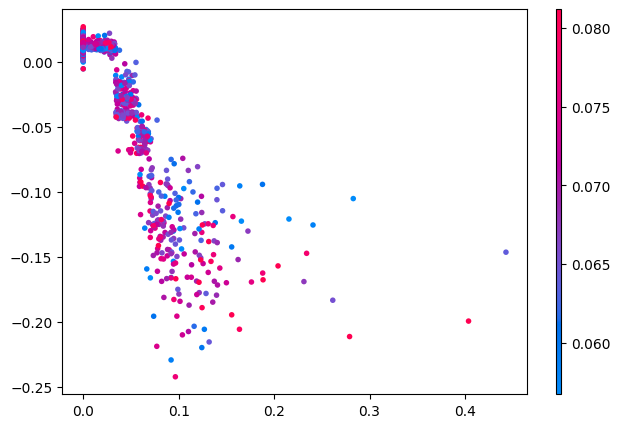

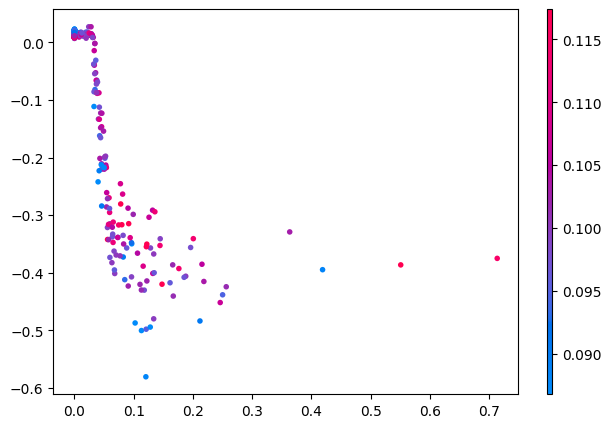

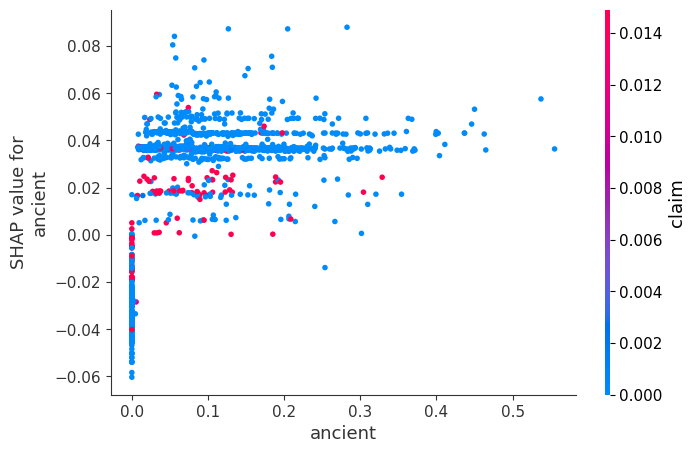

In [37]:
# Extract SHAP values
shap_values_array = shap_values.values  # Extract numerical values

# Ensure indices do not exceed available features
num_features = X_test.shape[1]  # Get number of features
top_features = np.argsort(np.abs(shap_values_array).mean(axis=0))[-3:]  # Top 3 features
top_features = [f for f in top_features if f < num_features]  # Remove out-of-bounds indices

# Generate dependence plots for valid features
for feature in top_features:
    try:
        shap.dependence_plot(feature, shap_values_array, shap_values.data, feature_names=vectorizer.get_feature_names_out())
    except:
        continue

C:\Users\wwwhh\AppData\Local\Temp\ipykernel_30256\2671323218.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_shap_values, y=top_feature_names, palette="viridis")


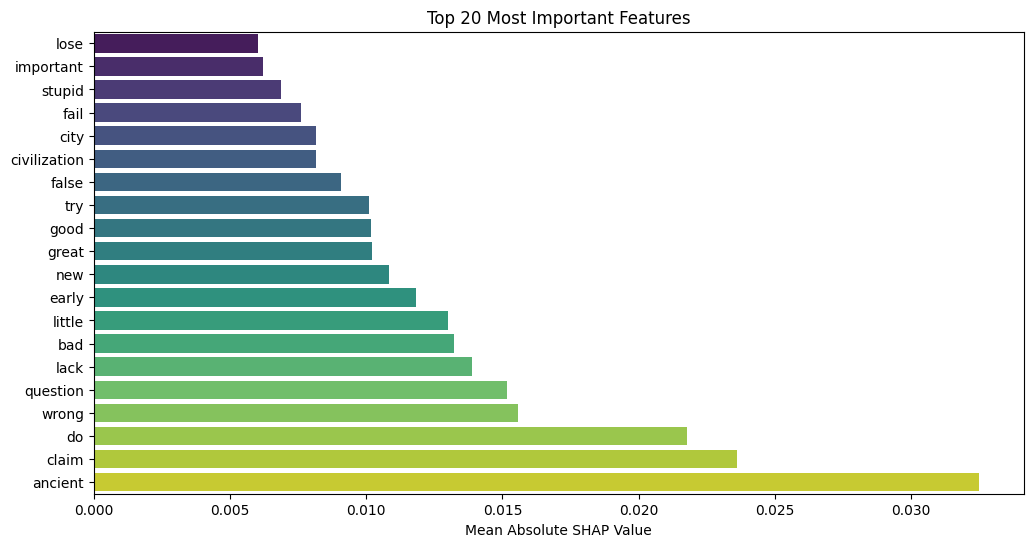

In [ ]:
shap_importance = np.abs(shap_values.values).mean(axis=0)

num_features = len(vectorizer.get_feature_names_out())

valid_indices = np.arange(num_features)
shap_importance = shap_importance[:num_features]

# Sort and get top 20 most important features
top_indices = np.argsort(shap_importance)[-20:]
top_shap_values = shap_importance[top_indices]
top_feature_names = [vectorizer.get_feature_names_out()[i] for i in top_indices]

# Plot Feature Importance
plt.figure(figsize=(12, 6))
sns.barplot(x=top_shap_values, y=top_feature_names, palette="viridis")
plt.xlabel("Mean Absolute SHAP Value")
plt.title("Top 20 Most Important Features")
plt.show()

In [41]:
from gensim.models import LdaModel

# Load the trained LDA model
lda_model = LdaModel.load("fyp_lda_model")  # Replace with actual path

# Load dictionary
from gensim.corpora import Dictionary
dictionary = Dictionary.load("fyp_dictionary.dict")  # Replace with actual path

In [ ]:
import lime.lime_text
from lime.lime_text import LimeTextExplainer
import numpy as np

# Define the explainer
explainer = LimeTextExplainer(class_names=[f"Topic {i}" for i in range(lda_model.num_topics)])

# Choose a sample document from your dataset
sample_doc = preprocessed_text_token[0]  # Replace with any sample document

# Convert document into LDA bag-of-words representation
sample_bow = dictionary.doc2bow(sample_doc)

# Define a function for LIME to predict topic probabilities
def lda_predict_proba(texts):
    bow_texts = [dictionary.doc2bow(text.split()) for text in texts]
    topic_probs = [dict(lda_model.get_document_topics(bow, minimum_probability=0)) for bow in bow_texts]
    topic_matrix = np.array([[topic_probs[i].get(topic, 0) for topic in range(lda_model.num_topics)] for i in range(len(texts))])
    return topic_matrix

# Generate LIME explanation
exp = explainer.explain_instance(" ".join(sample_doc), lda_predict_proba, num_features=10)

# Show explanation
exp.show_in_notebook
